# Sophisticated inference

This notebook demonstrates tree searching policies.

In [1]:
import jax.numpy as jnp
from jax import random as jr

key = jr.PRNGKey(0)

In [2]:
import networkx as nx
from pymdp.jax.envs import GraphEnv


def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }


graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
env = GraphEnv(graph, object_locations=[3], agent_locations=[0])

In [3]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = Agent(A, B, C, D, None, None, None, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=1)

In [4]:
keys = jr.split(key, 2)
key = keys[0]
obs, env = env.step(keys[1:])

In [5]:
print(obs)

[Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


In [6]:
empirical_prior = agent.D

qs = agent.infer_states(
    observations=obs,
    past_actions=None,
    empirical_prior=empirical_prior,
    qs_hist=None,
)

In [7]:
print(qs)

[Array([[[1.0000000e+00, 1.2888965e-18, 1.2888965e-18, 1.2888965e-18,
         1.2888965e-18, 1.2888965e-18, 1.2888965e-18]]], dtype=float32), Array([[[3.1720716e-17, 1.4285715e-01, 1.4285715e-01, 1.4285715e-01,
         1.4285715e-01, 1.4285715e-01, 1.4285715e-01, 1.4285715e-01]]],      dtype=float32)]


In [8]:
print(qs[0].shape)

(1, 1, 7)


In [9]:
from pymdp.jax.planning import tree_search

tree = tree_search(agent, qs, 3)

(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)
(1, 7)
(7, 1, 7)


In [14]:
import matplotlib.pyplot as plt

def plot_plan_tree(
    tree,
    policy_label=lambda x: "{:.2f}".format(x["G"]),
    observation_label=lambda x: "{:.2f}".format(x["G"]),
    font_size=12,
    depth=-1,
):
    # we can pass in a node or the whole tree list object
    root_node = tree.root()

    # create graph
    count = 0
    G = nx.Graph()
    to_visit = [(root_node, 0)]
    labels = {}

    G.add_node(count)
    count += 1

    # visit children
    while len(to_visit) > 0:
        node, id = to_visit.pop()
        for child in node["children"]:
            G.add_node(count)
            G.add_edge(id, count)

            to_visit.append((child, count))
            count += 1.0

    #from networkx.drawing.nx_pydot import graphviz_layout

    #pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        with_labels=True,
        font_size=font_size,
    )

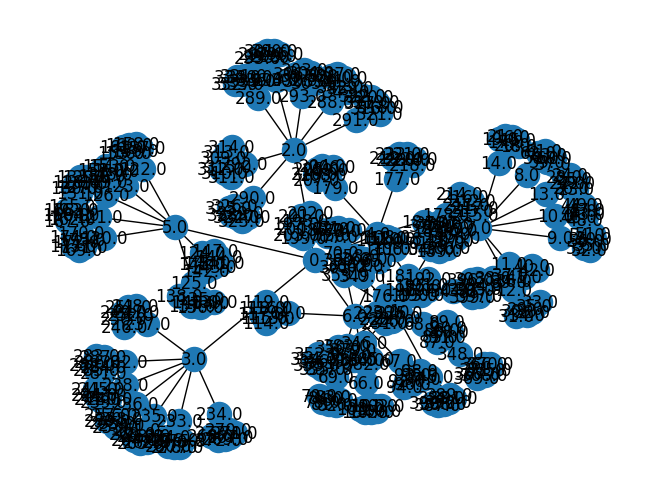

In [15]:
plot_plan_tree(tree)